# Introduction

The goal of this project is to analize data from NFL teams spacificly looking at the offenseive and deffenseive score, rush yards, passing yards, and turn overs.

Questions: <br>
- What teams did our team win against and did the team go to the playoffs?
- Are there any patterns or trends in a teams preformace over the season?
- Does the teams record corolate with the offenseive yardage, deffenseive yardage, or turn overs?
- How does team score and rush yards, pass yards, and total yards look over time. 


### Collect & Clean Data

This data was collected From https://www.pro-football-reference.com website 

**Data in our columns:**<br>
**Week**: The week of the football season in which the game was played.<br>
**Day**: The day of the week on which the game was played.<br>
**Date**: The date on which the game was played.<br>
**OT**: Indicates whether the game went into overtime or not.<br>
**Rec**: The record of the team playing the game at the time of the game.<br>
**Opp**: The record of the opposing team at the time of the game.<br>
**Tm**: The total points scored by the team playing the game.<br>
**Opp**: The total points scored by the opposing team.<br>
**1stD**: The number of first downs achieved by the team playing the game.<br>
**TotYd**: The total yards gained by the team playing the game.<br>
**PassY**: The total passing yards gained by the team playing the game.<br>
**RushY**: The total rushing yards gained by the team playing the game.<br>
**TO**: The number of turnovers committed by the team playing the game.<br>
**Offense**: The performance of the team's offense in the game.<br>
**Defense**: The performance of the team's defense in the game.<br>
**Sp. Tms**: The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game.<br>

In [1]:
# Dictonary of the description of every column in the dataset, for less scrolling. 
Description = {
    "Week": "The week of the football season in which the game was played.",
    "Day": "The day of the week on which the game was played.",
    "Date": "The date on which the game was played.",
    "OT": "Indicates whether the game went into overtime or not.",
    "Rec": "The record of the team playing the game at the time of the game.",
    "Opp": "The record of the opposing team at the time of the game.",
    "Tm": "The total points scored by the team playing the game.",
    "Opp": "The total points scored by the opposing team.",
    "1stD": "The number of first downs achieved by the team playing the game.",
    "TotYd": "The total yards gained by the team playing the game.",
    "PassY": "The total passing yards gained by the team playing the game.",
    "RushY": "The total rushing yards gained by the team playing the game.",
    "TO": "The number of turnovers committed by the team playing the game.",
    "Offense": "The performance of the team's offense in the game.",
    "Defense": "The performance of the team's defense in the game.",
    "Sp. Tms": "The performance of the team's special teams (e.g., kickoffs, punts, returns) in the game.",
    "Defense_1stD": "The number of first downs allowed by the defense."
}



In [2]:
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm


In [3]:



# Defining a function to get a dictonary of all NFL teams.
class Nfl_stats:
    # Created an init method that sets a default dictonary that has its keays as nfl teams and values as the symbols to those teams
    
    def __init__(self):
        self.teams_symbols_dict = {}
        # setting url we want to get the data from using requests and beautifulsoup to find nfl teams 
        url = "https://www.pro-football-reference.com/teams/"
        html = requests.get(url).text
        soup = BeautifulSoup(html, 'html.parser')
        teams = soup.find("table", id="teams_active")

        # finding the team names in html
        all_team_names = teams.find_all("th", {"class":"left",'data-stat': 'team_name'})

        # team_names and urls for the teams
        team_names = []
        team_urls = []
        
        # parse throught data
        for i in all_team_names[1:]:
            team_links = i.find("a")
            team_names.append(team_links.text.lower())
            team_urls.append(team_links.get("href").split("/")[2])
            
        # updating teams_symbols_dict to show teams and symbols for those teams
        self.teams_symbols_dict.update(dict(zip(team_names, team_urls)))
        
            
        
    # Creating a dataframe that shows a team's stats for the season
    
    def team_stats(self, team, year):
        
        # using the teams and symbols dictonary to find the each teams data
        teams_dict = self.teams_symbols_dict
        url = "https://www.pro-football-reference.com/teams/"

        #making it easier to find the team's name in the teams_symbols_dict even if its uppercase or just the teams name not the city.
        full_team_name = ""
        for correct_team in teams_dict:
            if team in correct_team:
                full_team_name = correct_team
        
        # finding the team's stats 
        team_symbol = teams_dict[full_team_name.lower()]
        url = f"{url}{team_symbol}/{year}.htm"
        html = requests.get(url).text
        soup = BeautifulSoup(html, "html.parser")
        table = soup.find("table", id="games")

        table_rows = table.find_all("tr")[2:]
        data = []
        for tr in table_rows:
            data.append([table_data.get_text(strip=True) for table_data in tr.find_all("td")])

        # creating a dataframe with the team's stats
        df = pd.DataFrame(data)
        
        # only getting the data from the columns that are relevent to the teams stats
        index = [0,1,4,6,8,9,10] + list(range(11,21))
        new_data = df.iloc[:,index].copy()

        # finding column names
        columns_html = table.find_all("th", {"scope":"col"})
        columns = []

        for col in columns_html[1:]:
            columns.append(col.text)
        # changing some column names and some that are duplicate so then we dont change both in dataframe later on
        columns[4] = "Result"
        columns[17] = "Toyd"
        columns[10] = "opp"
        columns[-4] = "Opp_TO"
        columns[-5] = "Opp_RushY"
        columns[-6] = "Opp_PassY"
        columns[-8] = "Opp_1stD"
        new_data.columns = [columns[num] for num in index]
        # renaming columns in our dataframe so the stats match up
        team_stats_df = new_data.rename({
            "Rec": "Record", 
            "Opp": "Opposing_team",
            "Tm":"Team_score",
            "TotYd": "Offense_TotYd",
            "Toyd": "Opp_TotYd",
            "opp": "Opponent_score",
            "TO":"Offense_TO",
            "RushY": "Offense_RushY",
            "PassY": "Offense_PassY",
            "1stD": "Offense_1stD"


        }, axis="columns")

        # replacing some columns into numbers so then we can do better analysis
        result_encoder = {'Result': {'L': 0, 'T': 0,'W': 1,' ' : pd.NA}}
        team_stats_df.replace(result_encoder, inplace=True)
        
        # creating a week column so we know what week it is in the season
        week = list(range(1,len(team_stats_df) + 1))
        team_stats_df.insert(0, "Week", week)

        # creting a column for the team we wanted to see and making the first letter a capitol letter.
        team_name_col = pd.Series([f"{team.title()}"]).repeat(len(team_stats_df)).reset_index(drop=True)

        team_stats_df.insert(0,"Team_name", team_name_col)
        
        # making that need to be numbers into int's
        columns_int_list = ["Result","Team_score","Opponent_score","Offense_1stD","Offense_TotYd","Offense_PassY","Offense_RushY","Offense_TO","Opp_1stD","Opp_TotYd","Opp_PassY","Opp_RushY","Opp_TO"]
        for column in columns_int_list:
            columns_list_na = team_stats_df[column].replace(["","bye"],0)
            team_stats_df[column]= columns_list_na.astype(int)
        
        return team_stats_df


### Explore Data

Let's use our object and input the data we want to get, we are useing panthers data from 2022.


In [4]:
# calling the  
# to create an object we call Nfl_stats().team_stats("team name", Year)
team_data = Nfl_stats().team_stats("panthers", 2022)
team_data

,Team_name,Week,Day,Date,Result,Record,Opposing_team,Team_score,Opponent_score,Offense_1stD,Offense_TotYd,Offense_PassY,Offense_RushY,Offense_TO,Opp_1stD,Opp_TotYd,Opp_PassY,Opp_RushY,Opp_TO
0,Panthers,1,Sun,September 11,0,0-1,Cleveland Browns,24,26,15,261,207,54,1,23,355,138,217,0
1,Panthers,2,Sun,September 18,0,0-2,New York Giants,16,19,18,275,129,146,2,18,265,162,103,0
2,Panthers,3,Sun,September 25,1,1-2,New Orleans Saints,22,14,12,293,148,145,0,19,426,342,84,3
3,Panthers,4,Sun,October 2,0,1-3,Arizona Cardinals,16,26,11,220,180,40,3,20,338,206,132,1
4,Panthers,5,Sun,October 9,0,1-4,San Francisco 49ers,15,37,15,308,244,64,1,22,397,244,153,1
5,Panthers,6,Sun,October 16,0,1-5,Los Angeles Rams,10,24,8,203,110,93,1,22,360,249,111,1
6,Panthers,7,Sun,October 23,1,2-5,Tampa Bay Buccaneers,21,3,14,343,170,173,0,17,322,276,46,0
7,Panthers,8,Sun,October 30,0,2-6,Atlanta Falcons,34,37,23,478,309,169,1,21,406,239,167,2
8,Panthers,9,Sun,November 6,0,2-7,Cincinnati Bengals,21,42,13,228,164,64,3,30,464,223,241,0
9,Panthers,10,Thu,November 10,1,3-7,Atlanta Falcons,25,15,18,333,101,232,0,20,291,153,138,1


In [5]:
# shape of dataset
rows = team_data.shape[0]
columns = team_data.shape[1]

print(f"There are {rows} rows and {columns} coulumns within this dataset.")


There are 18 rows and 19 coulumns within this dataset.


In [6]:
num_teams_played = team_data[team_data["Opposing_team"] != "Bye Week"].groupby("Opposing_team").size().count()

print("Number of teams played against: " + str(num_teams_played))


teams_played = team_data.groupby("Opposing_team").size()
teams_played = teams_played[teams_played.index != "Bye Week"]
print("\n"
      "Breakdown of teams they played: \n",
      teams_played)

print("\nTeams played more than once: \n" +f"{str(teams_played[teams_played == 2])}")



Number of teams played against: 14

Breakdown of teams they played: 
 Opposing_team
Arizona Cardinals       1
Atlanta Falcons         2
Baltimore Ravens        1
Cincinnati Bengals      1
Cleveland Browns        1
Denver Broncos          1
Detroit Lions           1
Los Angeles Rams        1
New Orleans Saints      2
New York Giants         1
Pittsburgh Steelers     1
San Francisco 49ers     1
Seattle Seahawks        1
Tampa Bay Buccaneers    2
dtype: int64

Teams played more than once: 
Opposing_team
Atlanta Falcons         2
New Orleans Saints      2
Tampa Bay Buccaneers    2
dtype: int64


In [7]:
missing_values = team_data.isna().sum()

print("The amount of missing values for this dataset in each column: \n\n" + str(missing_values))

The amount of missing values for this dataset in each column: 

Team_name         0
Week              0
Day               0
Date              0
Result            0
Record            0
Opposing_team     0
Team_score        0
Opponent_score    0
Offense_1stD      0
Offense_TotYd     0
Offense_PassY     0
Offense_RushY     0
Offense_TO        0
Opp_1stD          0
Opp_TotYd         0
Opp_PassY         0
Opp_RushY         0
Opp_TO            0
dtype: int64


In [8]:
unique_days = team_data.Day.unique()[team_data.Day.unique() != ""]
print(f"Unique days played: {unique_days}")

num_unique_days_played = team_data[team_data.Day != ""].groupby("Day")["Day"].count()

print(f"\nCount of days team played: \n{num_unique_days_played}")


Unique days played: ['Sun' 'Thu' 'Sat']

Count of days team played: 
Day
Sat     1
Sun    15
Thu     1
Name: Day, dtype: int64


### Analyze Data

Looking at the teams our team won aginanst. 

In [9]:
won_against = team_data[team_data.Result == 1].Opposing_team
print(f"\nWon against: \n{won_against.to_string(index=False)}")

lost_against = team_data[team_data.Result == 0].Opposing_team
print(f"\nLost against: \n{lost_against.to_string(index=False)}")


Won against: 
  New Orleans Saints
Tampa Bay Buccaneers
     Atlanta Falcons
      Denver Broncos
    Seattle Seahawks
       Detroit Lions
  New Orleans Saints

Lost against: 
    Cleveland Browns
     New York Giants
   Arizona Cardinals
 San Francisco 49ers
    Los Angeles Rams
     Atlanta Falcons
  Cincinnati Bengals
    Baltimore Ravens
            Bye Week
 Pittsburgh Steelers
Tampa Bay Buccaneers


In [19]:
team_score_win = team_data[team_data.Result == 1].Team_score.mean()
team_score_loss = team_data[team_data.Result == 0].Team_score.mean()

opp_score_win = team_data[team_data.Result == 0].Opponent_score.mean()
opp_score_loss = team_data[team_data.Result == 1].Opponent_score.mean()

print(f"The average score when the team wins a game is {team_score_win}. \nThe average score when the team losess is {round(team_score_loss,2)}.")

print(f"\nThe average score when the opponent wins is {round(opp_score_win,2)} \nThe average score when the opponenet losses is {round(opp_score_loss,2)}")

The average score when the team wins a game is 24.0. 
The average score when the team losess is 17.9.

The average score when the opponent wins is 27.8 
The average score when the opponenet losses is 13.71


In [11]:
avg_score = round(team_data["Team_score"].mean(),2)


avg_opp_score = round(team_data["Opponent_score"].mean(),2)
team = team_data["Team_name"].unique()
print(f"{team[0]} score {avg_score} on average, their opponents average score is {avg_opp_score}")


playoffs = team_data["Date"] == "Playoffs"

if playoffs.any():
    print(f"{team} made it to the playoffs!")
else:
    print(f"{team[0]} did not make it to the playoffs.")

team_result = team_data.Result
print(f"\nGames won: {str(team_result.sum())}")
print(f"Games lost: {str(team_result.count()-team_result.sum())}")

Panthers score 19.28 on average, their opponents average score is 20.78
Panthers did not make it to the playoffs.

Games won: 7
Games lost: 11


Here we careated an object that can show us offense and opponent bar graphs and the weather they won or loss. 
<br>The first parameter asks for the data, the second parameter can be offense or opponenet's data, the third parameter is to show the chrats or not, last parameter is to all the charts to a png.

In [12]:
# changing index to show from 1 to the length of the data inseted of starting from 0 
team_data.index = range(1,len(team_data)+1)

# excluding rows that have blank data so the data is less affected 
team_data = team_data[(team_data["Opposing_team"] != "Bye Week") & (team_data["Date"] != "Playoffs")]


# creating a function to show a bar graph for the offensive and defensive side of the team 
# the function will take 4 parameters the data, defense or offense side we want to visualize, to show chart or not, and to save to png
def full_bargraphs(data, side="Offense",show_chart=True,save=False):
    
    # filtering the data to only get the side we want
    stats = data.filter(regex=side).copy()
    
    # adding column for result to so we can include it in our bar graph
    stats["Result"] = data.Result.values
    
    #changing the name from Opp to Opponent 
    stats.columns = stats.columns.str.replace("Opp_", "Opponent_")
    
    # empty list for each chart
    charts = []
    # using a for loop to create all bar graphs at once
    for col in stats.iloc[:,:-1]:
        
        # using sns and plt to create figure, barplot, legend,add text under the graph, and add titles
        fig = plt.figure(figsize=(8,7))
        plot = sns.barplot(x=stats.index, y=col, data=stats, hue="Result",dodge=False, palette={1: "green", 0: "orange"});
        legend_elements = [plt.Rectangle((0,0), 1, 1, color='orange', label='Loss'),plt.Rectangle((0,0), 1, 1, color='green', label='Win')]
        legend = plt.legend(handles= legend_elements,title="Result",labels=["Loss", "Win"], loc="upper left")
        
        
        #spliting column name to create the title and make it more readable
        title = col.split("_")
        chart_title = plt.title(title[0]+ " " + title[1] +" Bar Chart")
        
        # getting the mean for each column during a loss or a win
        mean_win = round(stats[stats["Result"]== 1][col].mean(),2)
        mean_loss = round(stats[stats["Result"]== 0][col].mean(),2)
        
        # adding text to the bottom of the graph to show the mean for each 
        plt.figtext(.5,.052,f"\nThe {title[0].lower()}'s average number of {title[1]}'s when the result is a win: {str(mean_win)}",ha="center", fontsize=13)
        plt.figtext(.5,.00067,f"The {title[0].lower()}'s average number of {title[1]}'s when the ressult is a loss: {str(mean_loss)}",ha="center", fontsize=13)
        
        #adding the bar graphs to the empty chart list
        charts.append(plot)
        
        # using if statment to save the barchart if its True
        if save:
            plt.savefig(f"charts/{team_data.Team_name.unique()[0]} {title[0]} {title[1]}.png")
            
        # showing the chart if show_chart is True and closing the chart if show_chart it False
        if show_chart:
            plt.show()
            plt.close()
        else:
            plt.close()
    return charts

The bar graphs below show the offense's veriables with a different hue depending on weather the result is a win or a loss for each game, we can take a look at patterns that stand out. We can see some patterns in the graphs like rush yards, 1st downs, and turnovers. 
<br>

- If we look at 1st downs we can see that most yellow bars that have a higher number of 1st downs result in a loss.

- When we look at rush yards most yellow bars have more rush yards, which indicates that the more the rush yards the oppenent has the more likely they will win. 

- Looking at the opponent's turn overs we can see that the green bars that have higher turn overs result in a win. 

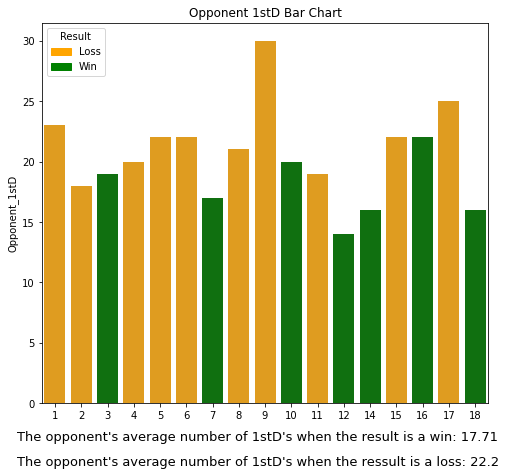

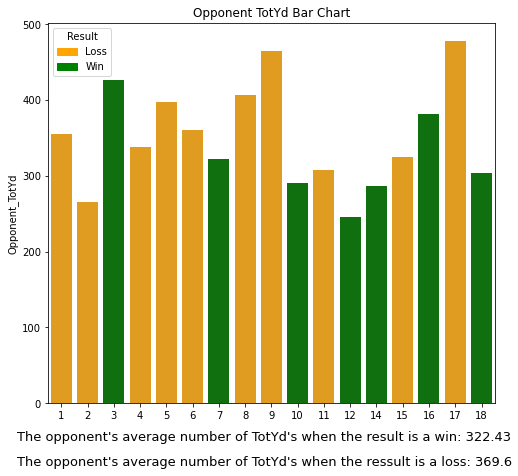

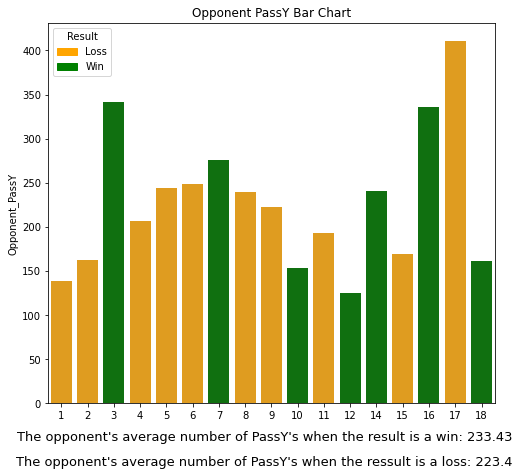

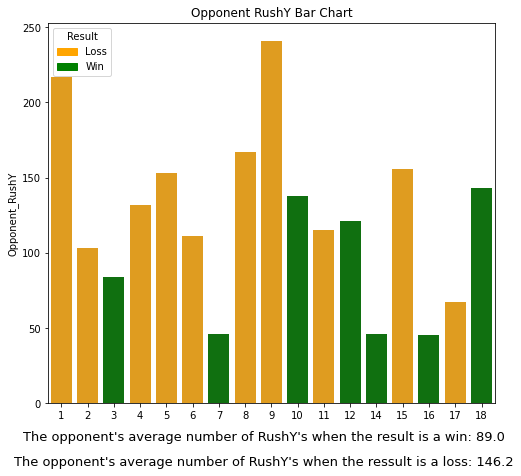

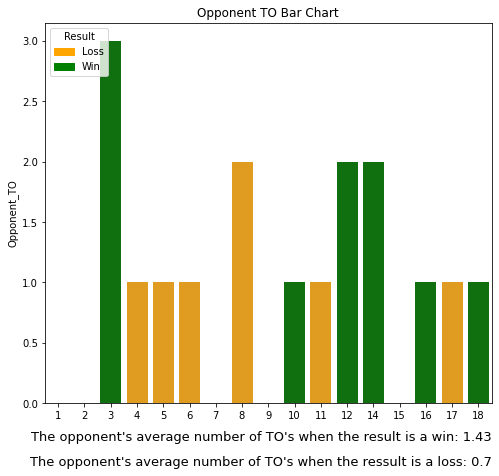

In [13]:
full_bargraphs(team_data,side="Opp_");

The bar graphs below show the offenseive veriables from our dataset, the hue is a different hue depending on weather the result is a win or a loss for each game. We will look at some patterns that stand out. 
<br>

- If we look at the offense rush yards we can see that there are more green bars where the result is a win when the rush yards are higher.
 
- When we look at offense turn overs we can see that its moslty yellow which means the result is mostly a loss when a the offense has turn overs. 

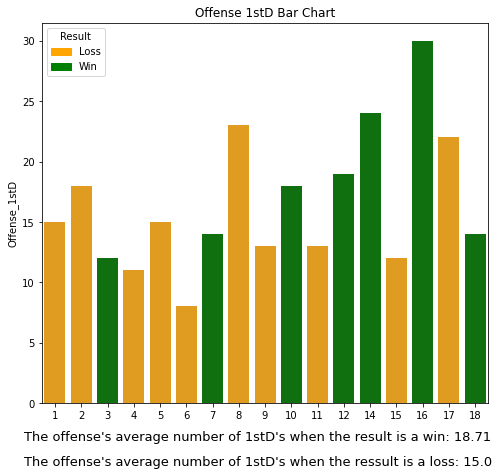

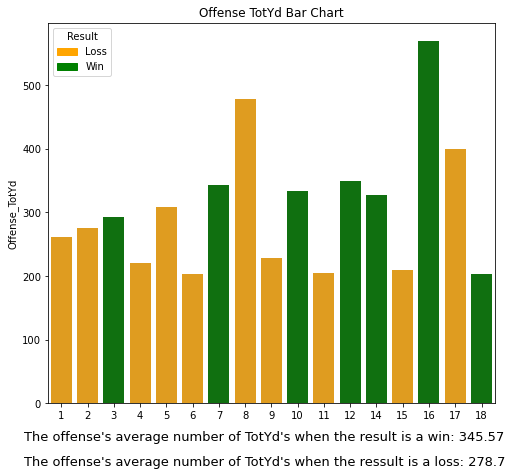

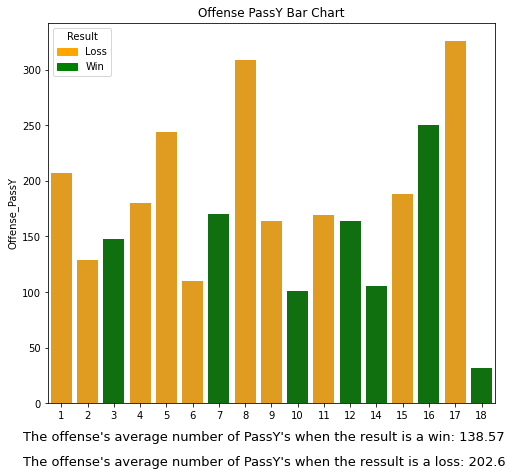

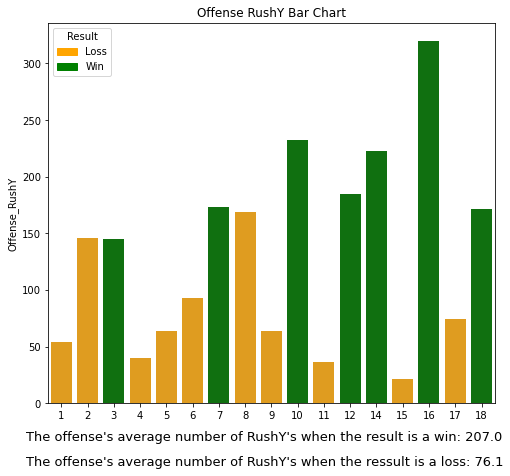

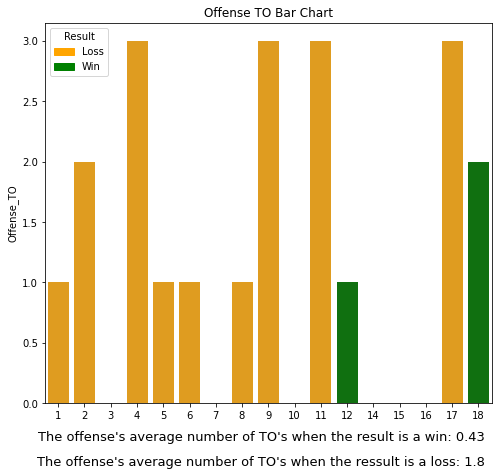

In [14]:
full_bargraphs(team_data);

Now that we looked at some patterns we can look at the correlation.
<br>Here we look at which veriables were correlated more than .50 or have a positive correlation, or less than .50 negitive correalation.

In [18]:
result_corrwith = team_data.corrwith(team_data["Result"])
score_corrwith = team_data.corrwith(team_data["Team_score"])

result_corr_positive = result_corrwith[team_data.corrwith(team_data["Result"]) >= .50]
score_corr_positive = score_corrwith[team_data.corrwith(team_data["Team_score"]) >= .50]


result_corr_negative = result_corrwith[team_data.corrwith(team_data["Result"]) <= -.50]
# there was no negative correlation on score of less than -.50


print(f"\nPositive Result Correlation Coefficient:  \n{result_corr_positive}\n\nNegative Result Correlation Coefficient: \n{result_corr_negative}")

print(f"\nPositive Score Correlation Coefficient: \n{score_corr_positive}")




Positive Result Correlation Coefficient:  
Result           1.000000
Offense_RushY    0.795404
dtype: float64

Negative Result Correlation Coefficient: 
Opponent_score   -0.657117
Offense_TO       -0.579534
Opp_1stD         -0.597754
Opp_RushY        -0.515995
dtype: float64

Positive Score Correlation Coefficient: 
Team_score       1.000000
Offense_1stD     0.793107
Offense_TotYd    0.843615
Offense_RushY    0.642299
dtype: float64


    Let's take a look at the correlation coefficients, A positive correlation coefficient indicates that the two variables  move in the same direction, while a negative correlation coefficient indicates that they move in opposite directions.
    
    A strong positive correlation of 0.79 was found between the team's score and the amount of rushing yards they gained. This means that teams with more rushing yards are more likely to score points.
    
    There is also a negative correlation between the result and opponent score, offense turn overs, and opponent 1st downs. This means that the higher the team score the more likely our team will lose, the more the turn overs the offense has the more likely our team will lose, and the more 1st downs the opponent team has the more likely our team will lose. 
    
    There is also a strong positive correaltion between score and offense 1st downs, offense total yards, and rush yards.
    If a team earns more 1st down's, total yards, and rush yards they are more likely to score points.


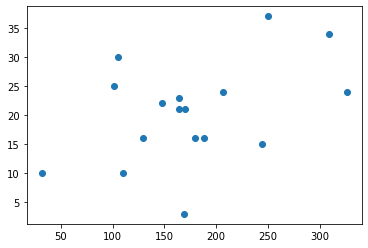

In [16]:
team_score = team_data.Team_score
team_rush = team_data.Offense_PassY

fig, ax = plt.subplots()
ax.scatter(team_rush, team_score)

### Conclusions